In [1]:
import dgl
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info

In [2]:
import pandas as pd
from glob import glob
import numpy as np
from torch import tensor
import torch
import re
import csv
import sys
import os
import torch as th
import matplotlib.pyplot as plt

In [3]:
file = '~/Downloads/0229981-230224095556074.csv'  ## file location, gbif Solanacea

colnames = ['gbifID','occurrenceID','verbatimScientificName','verbatimScientificNameAuthorship','locality',
            'occurrenceStatus','decimalLatitude','decimalLongitude','day','month','year','basisOfRecord',
            'collectionCode','catalogNumber','recordNumber','dateIdentified','recordedBy','identifiedBy',
            'typeStatus','lastInterpreted','issue','stateProvince',
            'phylum','class','order','family','genus','species',
            'institutionCode','countryCode']

taxa_hierarchy = ['phylum', 'class', 'order', 'family', 'genus', 'species']

In [10]:
# Loads 10000 raw data samples (for demo only)
gbif_sample = pd.read_csv(file,nrows=10000,encoding='utf-8',sep='\\t',usecols=colnames,on_bad_lines='skip',engine='python')
gbif_sample.head()

,gbifID,occurrenceID,phylum,class,order,family,genus,species,verbatimScientificName,verbatimScientificNameAuthorship,...,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,recordedBy,typeStatus,lastInterpreted,issue
0,14507359,NaN,Tracheophyta,Magnoliopsida,Solanales,Solanaceae,Alkekengi,Alkekengi officinarum,Physalis alkekengi L.,NaN,...,Conservatoire botanique national du Bassin par...,Conservatoire botanique national du Bassin par...,20010122165146por,NaN,NaN,NaN,NaN,NaN,2023-05-09T00:56:41.255Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...
1,21516372,NaN,Tracheophyta,Magnoliopsida,Solanales,Solanaceae,Solanum,Solanum dulcamara,Solanum dulcamara L.,NaN,...,Conservatoire botanique national du Bassin par...,Conservatoire botanique national du Bassin par...,20030902144741Per,NaN,NaN,NaN,Lebreton Alexis,NaN,2023-05-09T00:56:30.181Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...
2,14517827,NaN,Tracheophyta,Magnoliopsida,Solanales,Solanaceae,Alkekengi,Alkekengi officinarum,Physalis alkekengi L.,NaN,...,Conservatoire botanique national du Bassin par...,Conservatoire botanique national du Bassin par...,20040203153749Per,NaN,NaN,NaN,Jame,NaN,2023-05-09T00:56:47.180Z,INSTITUTION_MATCH_NONE
3,10592424,NaN,Tracheophyta,Magnoliopsida,Solanales,Solanaceae,Datura,Datura stramonium,Datura stramonium L.,NaN,...,Conservatoire botanique national du Bassin par...,Conservatoire botanique national du Bassin par...,20040203155458Per,NaN,NaN,NaN,Jame,NaN,2023-05-09T00:56:28.047Z,INSTITUTION_MATCH_NONE
4,21475075,NaN,Tracheophyta,Magnoliopsida,Solanales,Solanaceae,Solanum,Solanum dulcamara,Solanum dulcamara L.,NaN,...,Conservatoire botanique national du Bassin par...,Conservatoire botanique national du Bassin par...,19971126113009ref,NaN,NaN,NaN,Gaume Raymond,NaN,2023-05-09T00:56:42.507Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...


In [ ]:
# For large file, use chunks to load data
'''
GBIF Occurrence Download - 105,738,391 specimen records.
DOI: https://doi.org/10.15468/dl.5qqpak
'''
gbif_sample = pd.read_csv(file,chunksize=10000,encoding='utf-8',sep='\\t',usecols=colnames,on_bad_lines='skip',engine='python')
gbif_sample = pd.concat(gbif_sample)

In [11]:
'''This function that will go through the columns of the DataFrame in the order you specified and 
return the column name and the value of the deepest (i.e., closest to 'species') non-null value for each row.''' 

def get_bottom_taxa(df):
    taxa_hierarchy = ['phylum', 'class', 'order', 'family', 'genus', 'species']
    
    # Reverse the order of hierarchy to start from 'species' up to 'phylum'
    reversed_hierarchy = taxa_hierarchy[::-1]
    
    # Store the results in these lists
    # deepest_node_name_list = []
    deepest_node_value_list = []

    # Iterate over each row
    for idx, row in df.iterrows():
        # Check each column in the reversed order
        for col in reversed_hierarchy:
            # If the value in a column is not nan, it appends the column name and its content to the respective lists.
            if pd.notna(row[col]):
                # deepest_node_name_list.append(col)
                deepest_node_value_list.append(row[col])
                # Stop checking the rest columns
                break
        # If all values in a row are null, it appends None to the lists.
        else:
            # deepest_node_name_list.append(None)
            deepest_node_value_list.append(None)
            
    # Add the results to the dataframe
    # df['bottomTaxaRank'] = deepest_node_name_list
    df['taxonID'] = deepest_node_value_list

    return df

In [12]:
# Data preprocessing
get_bottom_taxa(gbif_sample)
gbif_sample.drop(taxa_hierarchy, axis=1, inplace=True)
gbif_columns = gbif_sample.columns.tolist()   ## load content into list

In [13]:
# A statistical analysis helper function 
def get_gbif_distribution(data):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = gbif_columns, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = gbif_sample[columnName].value_counts()
        data_distribution.update({columnName: temp})
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution, data_distribution_sum

                                    sum
gbifID                            10000
occurrenceID                       9598
verbatimScientificName            10000
verbatimScientificNameAuthorship   6405
countryCode                        8804
locality                           8248
stateProvince                      6054
occurrenceStatus                  10000
decimalLatitude                    3531
decimalLongitude                   3531
day                                6366
month                              7208
year                               7694
basisOfRecord                     10000
institutionCode                    9997
collectionCode                     9997
catalogNumber                     10000
recordNumber                       5430
identifiedBy                       4637
dateIdentified                     2822
recordedBy                         8764
typeStatus                          757
lastInterpreted                   10000
issue                             10000


<AxesSubplot:>

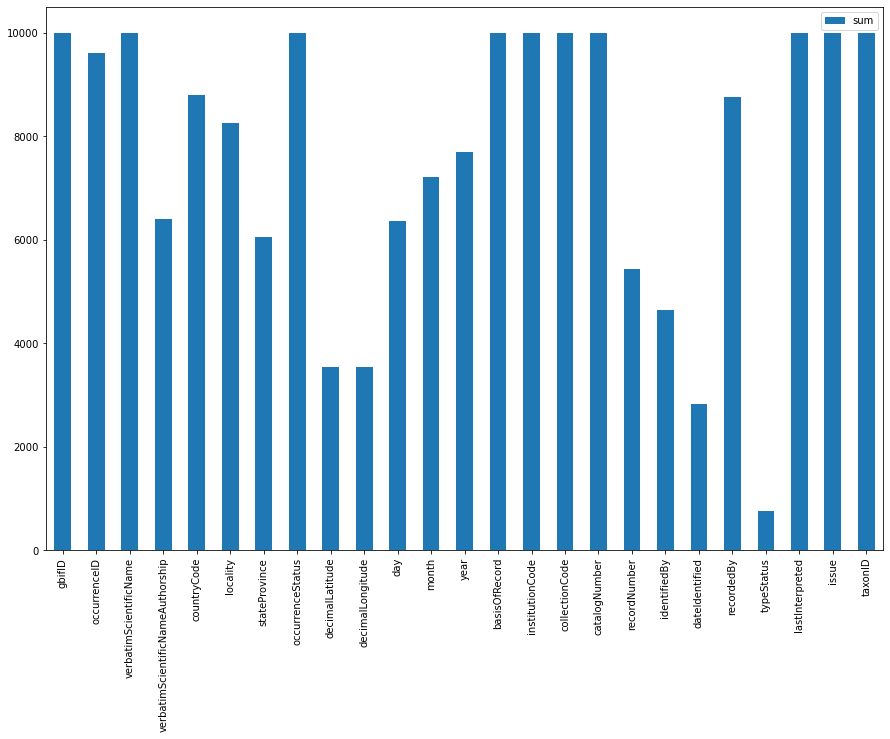

In [14]:
# Plot data distribution 
distribution, distribution_sum = get_gbif_distribution(gbif_sample)
print(distribution_sum.T)
distribution_sum.T.plot.bar(figsize=(15,10))

In [15]:
# Print the head of the "Specimen"
gbif_sample.head()

,gbifID,occurrenceID,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,decimalLatitude,decimalLongitude,...,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,recordedBy,typeStatus,lastInterpreted,issue,taxonID
0,14507359,NaN,Physalis alkekengi L.,NaN,FR,LAROCHE-SAINT-CYDROINE,NaN,PRESENT,47.9757,3.470130,...,Conservatoire botanique national du Bassin par...,20010122165146por,NaN,NaN,NaN,NaN,NaN,2023-05-09T00:56:41.255Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,Alkekengi officinarum
1,21516372,NaN,Solanum dulcamara L.,NaN,FR,Chateaudun,NaN,PRESENT,48.0761,1.324440,...,Conservatoire botanique national du Bassin par...,20030902144741Per,NaN,NaN,NaN,Lebreton Alexis,NaN,2023-05-09T00:56:30.181Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,Solanum dulcamara
2,14517827,NaN,Physalis alkekengi L.,NaN,FR,VRIGNE-AUX-BOIS,NaN,PRESENT,NaN,NaN,...,Conservatoire botanique national du Bassin par...,20040203153749Per,NaN,NaN,NaN,Jame,NaN,2023-05-09T00:56:47.180Z,INSTITUTION_MATCH_NONE,Alkekengi officinarum
3,10592424,NaN,Datura stramonium L.,NaN,FR,Sedan,NaN,PRESENT,NaN,NaN,...,Conservatoire botanique national du Bassin par...,20040203155458Per,NaN,NaN,NaN,Jame,NaN,2023-05-09T00:56:28.047Z,INSTITUTION_MATCH_NONE,Datura stramonium
4,21475075,NaN,Solanum dulcamara L.,NaN,FR,PREUILLY-SUR-CLAISE,NaN,PRESENT,46.8546,0.928775,...,Conservatoire botanique national du Bassin par...,19971126113009ref,NaN,NaN,NaN,Gaume Raymond,NaN,2023-05-09T00:56:42.507Z,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,Solanum dulcamara
